In [1]:
import numpy
from matplotlib import pyplot
from binascii import hexlify
from Crypto.Cipher import AES # Used for verification

import inspector_trace_loader

In [2]:
(traces, data) = inspector_trace_loader.load_trs("traces.trs")
plaintext = data[:, 0:16]
ciphertext = data[:, 16:32]

number_of_traces = traces.shape[0]
points_per_trace = traces.shape[1]

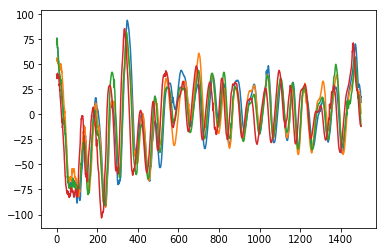

In [3]:
pyplot.figure()
pyplot.plot(traces[0, 2500:4000])
pyplot.plot(traces[1, 2500:4000])
pyplot.plot(traces[2, 2500:4000])
pyplot.plot(traces[3, 2500:4000])
pyplot.show()

In [4]:
# Naive Sum of Absolute Differences
def synchronize(trace, reference, window=[-1, -1], max_offset=500):
    if window[0] == -1:
        window[0] = 0
    if window[1] == -1:
        window[1] = len(reference) - 1
    window_size = window[1] - window[0]
    reference_window = reference[window[0]:window[1]]
    soad = [0] * (max_offset*2 + 1)
    for x in range(0, 2*max_offset+1):
        trace_slice = trace[window[0]-max_offset+x:window[1]-max_offset+x]
        soad[x] = numpy.sum(numpy.abs(reference_window - trace_slice))
    soad_index = numpy.argmin(soad)
    offset = -max_offset+soad_index
    synchronized_trace = trace
    if offset < 0:
        synchronized_trace = numpy.concatenate(([0]*abs(offset), synchronized_trace[:-abs(offset)]))
    elif offset > 0:
        synchronized_trace = numpy.concatenate((synchronized_trace[abs(offset):], [0]*abs(offset)))
    return synchronized_trace

In [5]:
# Synchronize traces
reference_trace = traces[0]
synchronized_traces = reference_trace
for trace in traces[1:]:
    synchronized_trace = synchronize(trace, traces[0], [2500, 4000])
    synchronized_traces = numpy.vstack((synchronized_traces, synchronized_trace))

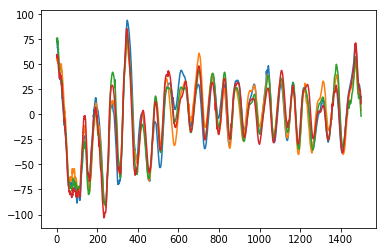

In [6]:
# Plot a few traces after synchronization
pyplot.figure()
pyplot.plot(synchronized_traces[0, 2500:4000])
pyplot.plot(synchronized_traces[1, 2500:4000])
pyplot.plot(synchronized_traces[2, 2500:4000])
pyplot.plot(synchronized_traces[3, 2500:4000])
pyplot.show()

In [7]:
# Model

# Hamming Weight look-up table
HW = [bin(n).count("1") for n in range(0, 256)]

sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

In [8]:
# This algorithm was taken from the ChipWhisperer wiki
#   https://wiki.newae.com/Tutorial_B6_Breaking_AES_(Manual_CPA_Attack)
bestguess = [0]*16
pge = [256]*16
for bnum in range(0, 16):
    cpaoutput = [0]*256
    maxcpa = [0]*256
    for kguess in range(0, 256):
        # Initialize arrays & variables to zero
        sumnum = numpy.zeros(points_per_trace)
        sumden1 = numpy.zeros(points_per_trace)
        sumden2 = numpy.zeros(points_per_trace)

        hyp = numpy.zeros(number_of_traces)
        for tnum in range(0, number_of_traces):
            hyp[tnum] = HW[intermediate(plaintext[tnum][bnum], kguess)]

        # Mean of hypothesis
        meanh = numpy.mean(hyp, dtype=numpy.float64)

        # Mean of all points in trace
        meant = numpy.mean(synchronized_traces, axis=0, dtype=numpy.float64)

        # For each trace, do the following
        for tnum in range(0, number_of_traces):
            hdiff = (hyp[tnum] - meanh)
            tdiff = synchronized_traces[tnum, :] - meant

            sumnum = sumnum + (hdiff*tdiff)
            sumden1 = sumden1 + hdiff*hdiff 
            sumden2 = sumden2 + tdiff*tdiff

        cpaoutput[kguess] = sumnum / numpy.sqrt(sumden1 * sumden2)
        maxcpa[kguess] = max(abs(cpaoutput[kguess]))

    bestguess[bnum] = numpy.argmax(maxcpa)

    cparefs = numpy.argsort(maxcpa)[::-1]

In [9]:
keybytes = bytes(bestguess)
print("Best key guess: {}".format(hexlify(keybytes)))

Best key guess: b'cafebabedeadbeef0001020304050607'


In [10]:
# Check key
aes = AES.new(keybytes)
aes.encrypt(plaintext[0]) == bytes(ciphertext[0])

True